In [ ]:
#see https://github.com/spacetelescope/notebooks/blob/master/notebooks/DrizzlePac/Initialization/Initialization.ipynb

conda deactivate
conda update --all
conda update -n astroconda --all
conda activate astroconda

conda install -c conda-forge astroquery
conda install -c conda-forge ccdproc

from astroquery.mast import Observations
import os
import shutil
import stwcs
import subprocess 

In [ ]:
obs_table = Observations.query_criteria(obs_id='ib2j02n5q', obstype='all')
download_tab = Observations.download_products(obs_table['obsid'], mrp_only=False, 
                                              productSubGroupDescription=['FLC'])

for file in download_tab['Local Path']:
    os.rename(file, os.path.basename(file))
    
shutil.rmtree('mastDownload')

os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))

subprocess.check_output('crds bestrefs --files ib2j02n5q_flc.fits --sync-references=1 --update-bestrefs', shell=True, stderr=subprocess.DEVNULL)

os.environ['iref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfc3')) + os.path.sep

stwcs.updatewcs.updatewcs('ib2j02n5q_flc.fits', use_db=False)


In [1]:
#purpose is to perform the image processing steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images

5) transfer to another notebook to perform relevant analyses: e.g. de-extinct all the images,
create apertures as appropriate for all the knots, taking ratio and then finding EDFs, 
summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  1.64 #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv



# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
#     if [badkey for badkey in wcs_header if badkey == 'ORGNAME'] == []:
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
#     else:
#         wcs_header = wcs_header.remove('ORGNAME')
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)

    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True, output_verify='ignore')     
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True, output_verify='ignore')
        
    return (save_path+new_filename)


#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')
    
    #plt.close() #only if doing on inanna

In [3]:
# path = 'hh6_imagejaligned/*'
path = 'hh6/*drz*'
# path = 'hh711/*'

files_data = [i.replace('\\', '/') for i in im_name_finder(path, 'fits')]
hdu_list = [fits.open(i) for i in files_data]

print(files_data)

hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

for count, hdu in enumerate(hdu_list):
        hdu_pix_list.append(hdu[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        hdu_fnu_list.append(hdu[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu[0].header['PHOTBW'])

#         reading in data for general use  and header for wcs
#         converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu[1].data * hdu[0].header['PHOTFLAM'] * hdu[0].header['PHOTBW'])
        print(hdu[0].header['PHOTPLAM']/1e-6*1e-10, hdu[0].header['PHOTFLAM'], hdu[0].header['PHOTBW'])
        hdu_header_list.append(hdu[1].header)

['hh6/idn107010_drz.fits', 'hh6/idn115010_drz.fits', 'hh6/idn123010_drz.fits']
1.6403508000000002 2.8256999e-19 700.06543
1.2584887000000002 4.9671002e-19 339.31592
1.2831845 4.3479999e-19 357.43805


In [4]:
path = 'hh6_imagejaligned/*10*'
# path = 'hh6/*drz*'
# path = 'hh711/*'

files_data = [i.replace('\\', '/') for i in im_name_finder(path, 'fits')]
hdu_list = [fits.open(i) for i in files_data]

print(files_data)

hdu_data_list = []
hdu_header_list = []

for count, hdu in enumerate(hdu_list):
        hdu_data_list.append(hdu[0].data * hdu_pixtorad_list[count]**2.)
        hdu_header_list.append(hdu[0].header)
        
#testing extinction with basic cropping of images excluding regridding...uses original data 


s = np.divide(hdu_data_list[1], hdu_data_list[0], out=np.zeros_like(hdu_data_list[1]), where=hdu_data_list[0]!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
file_start = ''
ratio_path = fits_saver(s, hdu_header_list[-1], '126_164_for_dext.fits', file_start) #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)


#de-extincting...
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
from scipy.interpolate import CubicSpline
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #interpolating
C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula
R_Fe = vs(0.547) / C_ext_Fe2const
s0 = 2.6

avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula  
hdu_deextinc = hdu_data_list[-1] * np.exp(tau_ext)
#     implot(hdu_deextinc, w, False, np.max(hdu_deextinc))  
deext_path = fits_saver(hdu_deextinc, hdu_header_list[-1], 'deext_164.fits', '')


# implot(data_ratio, wcscut, False, 2)



['hh6_imagejaligned/107010.fits', 'hh6_imagejaligned/1150101.fits']


<ipython-input-4-e50fe50c729d>:38: RuntimeWarning: divide by zero encountered in true_divide
  avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
<ipython-input-4-e50fe50c729d>:38: RuntimeWarning: invalid value encountered in log10
  avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
<ipython-input-4-e50fe50c729d>:39: RuntimeWarning: divide by zero encountered in true_divide
  tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula
<ipython-input-4-e50fe50c729d>:39: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula
<ipython-input-4-e50fe50c729d>:40: RuntimeWarning: invalid value encountered in multiply
  hdu_deextinc = hdu_data_list[-1] * np.exp(tau_ext)


In [4]:
def edf_calc(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / (n)
    
    #alt method from https://stackoverflow.com/questions/42147206/normalizing-cdf-in-python
    num_bins = 2500
    x = data[~np.isnan(np.sort(data))]
    counts, bin_edges = np.histogram(x, bins=num_bins, range=(np.nanmin(x), np.nanmax(x)), density=True)
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate and plot CDF of sample 
    cdf = np.cumsum(counts)
    scale = 1.0/cdf[-1]
    norm_cdf = scale * cdf
    
    return(center, norm_cdf)

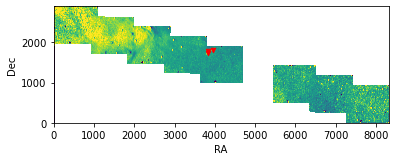

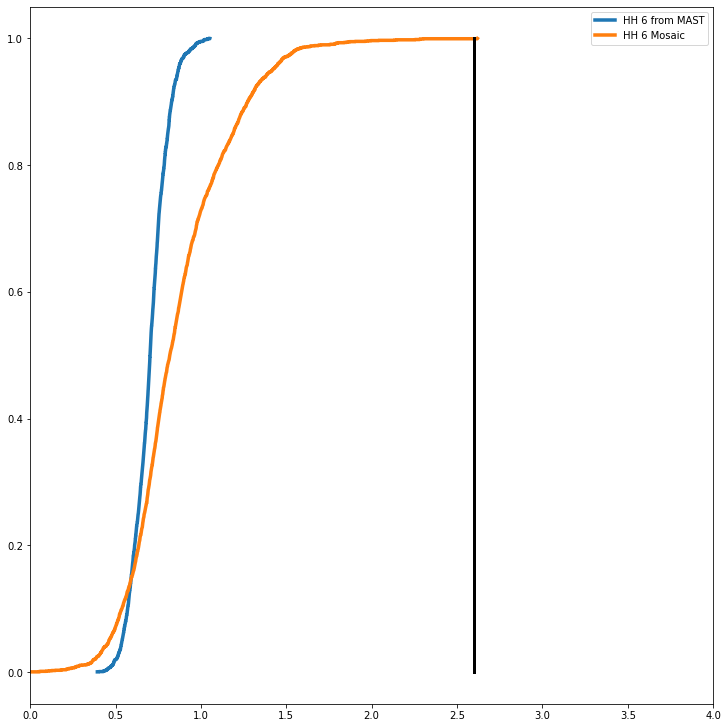

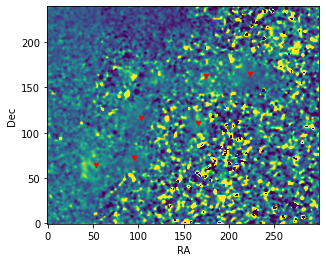

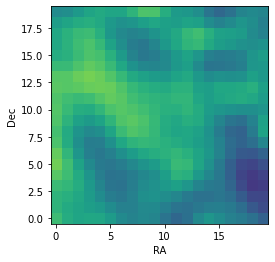

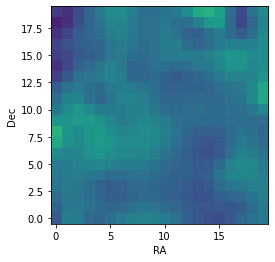

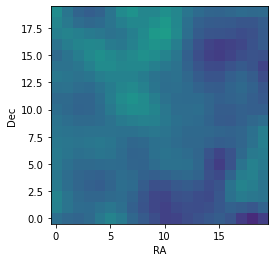

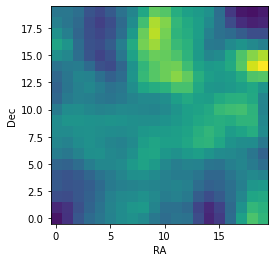

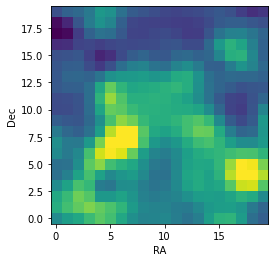

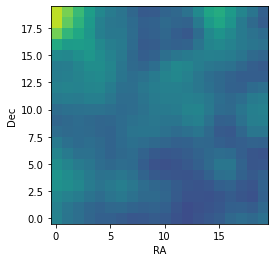

In [14]:
#trying to find EDFs of raw data...
w = WCS(hdu_header_list[0])

implot(s, w, False, 1)


# position = (3870, 1770)  #x, y! - in pix space
# size = (250, 300)  #y, x!...necessary b/c of how cutout works - in wcs or sky coords   
# vmax = 1e-16   
       
# cutout = Cutout2D(s, position, size, wcs = w)
# datacut = cutout.data

# #fixing wcs
# wcscut = cutout.wcs 
# wcs_header_cut = wcscut.to_header()

# implot(datacut, wcscut, False, 1)




# import sys
# sys.exit()







coords_list = [[(3828, 1773), (23, 24)],
               [(3828, 1728), (24, 31)],
               [(3946, 1818), (33, 33)],]

# [[(3778, 1713), (24, 36)],
#                [(3828, 1728), (24, 31)],
#                [(3828, 1773), (23, 24)],
#                [(3893, 1750), (44, 21)],
#                [(3905, 1808), (24, 27)],
#               [(3946, 1818), (33, 33)],
#               [(3819, 1815), (23, 19)],
#               [(3850, 1813), (25, 21)],]

# aperture_size = 20
# coords_list = [[(3775, 1710), (aperture_size, aperture_size)],
#                [(3820, 1718), (aperture_size, aperture_size)],
#                [(3826, 1762), (aperture_size, aperture_size)],
#               [(3893, 1759), (aperture_size, aperture_size)],
#               [(3905, 1808), (aperture_size, aperture_size)],
#               [(3945, 1811), (aperture_size, aperture_size)],]

for j in range(len(coords_list)):
        #unpacking coords
    position = coords_list[j][0]
    size = coords_list[j][1]
    
    plt.scatter(int(position[0]), int(position[1]), marker='v', color='red', s=20)


    
    

    
    

hh6_concat = [] #initializing list to join all the hh6 knots

fig, (ax1) = plt.subplots(1, figsize=(10,10), sharex=True, constrained_layout=True)

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(s, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data and plotting EDF
    flat_data = np.sort(datacut.flatten())
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)

    xedf, yedf = edf_calc(flat_data)
    # plt.figure(111)
#     plot_color = ax1.plot(xedf, yedf, label =  'knot'+str(i), linewidth = 3.5, linestyle='-')
    # print(plot_color.get_facecolor())
    
xedf, yedf = edf_calc(hh6_concat)
plot_color = ax1.plot(xedf, yedf, label =  'HH 6 from MAST', linewidth = 3.5, linestyle='-')
ax1.legend()
# ax1.plot([2.6, 2.6], [0,1], label ='This Work (2.6)', color='black', linestyle='-', linewidth=3)

plt.xlim(0, 4)





















def file_open(file):
    hdu1 = fits.open(file)  #import image
    w = WCS(hdu1[0].header)   #get wcs coords
    data = hdu1[0].data  #getting data from hdu
    hdu1.close()

    return w, data



#histogramming a different way...

file = r'../Image Analysis/reset_allsteps_3_21_22/conv_126_164_for_dext.fits' #a file of the full 1.26/1.64 micron, convolved image (no regridding done, just a minor cutout to crop to same size)
w, data = file_open(file)

# '''
# # HH 6:
# # # '''
# position = (4725, 2875)  #x, y!
# size = (240, 300)  #y, x!...necessary b/c of how cutout works
# name = 'hh6_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''

#unpacking coords
hh6_position = (4725, 2875)
hh6_size = (240, 300)

#cutting out coordinates
hh6_cutout = Cutout2D(data, hh6_position, hh6_size, wcs = w)
hh6_datacut = hh6_cutout.data
hh6_wcscut = hh6_cutout.wcs




implot(hh6_datacut, hh6_wcscut, False, 2)
coords_list = [[(53, 64), (14, 14)], [(95, 72), (7, 15)],[(103, 116), (16, 14)],[(166, 111), (22, 19)],[(175, 163), (17, 16)],[(223, 165), (22, 21)],]
for i in range(len(coords_list)):
    position = coords_list[i][0]
    plt.scatter(int(position[0]), int(position[1]), marker='v', color='red', s=20)
    


# coords_list = [[(53, 64), (38, 35)], [(95, 72), (17, 29)],[(103, 116), (35, 34)],[(166, 111), (38, 38)],[(175, 163), (30, 29)],[(223, 165), (34, 37)],]
# coords_list = [[(53, 64), (14, 14)], [(95, 72), (7, 15)],[(103, 116), (16, 14)],[(166, 111), (22, 19)],[(175, 163), (17, 16)],[(223, 165), (22, 21)],]
aperture_size = 20
coords_list = [[(53, 64), (aperture_size, aperture_size)], [(95, 72), (aperture_size, aperture_size)],[(103, 116), (aperture_size, aperture_size)],[(166, 111), (aperture_size, aperture_size)],[(175, 163), (aperture_size, aperture_size)],[(223, 165), (aperture_size, aperture_size)],]
hh6_concat = [] #initializing list to join all the hh6 knots

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(hh6_datacut, position, size, wcs = hh6_wcscut)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data
    flat_data = np.sort(datacut.flatten())
    
    #incase needing to restrict data...
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)
    
    
    implot(datacut, wcscut, False, 2)
    


xedf, yedf = edf_calc(hh6_concat)
a0 = int(0)
af = int(6575)

# plt.figure(113)
# n, bins, patches = ax2.hist(hh6_concat, label = 'HH 6 Mosaic', density=False, histtype ='step', bins=50, linewidth=2, color='green')  # density=False would make counts
plot_color = ax1.plot(xedf, yedf, label =  'HH 6 Mosaic', linewidth = 3.5, linestyle='-')
ax1.legend()
ax1.plot([2.6, 2.6], [0,1], label ='Research Note (2.6)', color='black', linestyle='-', linewidth=3)

# print('hh6, 12 bins, N/sqrt(N)', n[-15:] / np.sqrt(n[-15:]), 'bin loc', bins[-15:])
# print(bins[0:-13], len(bins), len(n))
# print('fraction of total counts for hh6 @ 2.6', np.sum(n[0:-13]) / np.sum(n))


# plt.figure(113)
# ax2.set_title('first deriv (histogram)')

# ax2.set_ylim(1, 1e3)
# ax2.set_xlim(0, 4)
# ax2.set_yscale('log')
# ax2.set_ylabel('Number of Pixels')
# ax2.set_xlabel(r'$\rm [1.26 \, \mu m \, / \, 1.64 \, \mu m]$ Intensity')
# ax2.legend(loc='upper right')


In [6]:
path = 'hh6_imagejaligned/*forbowshock*'
# path = 'hh6/*drz*'
# path = 'hh711/*'

files_data = [i.replace('\\', '/') for i in im_name_finder(path, 'fits')]
hdu_list = [fits.open(i) for i in files_data]

print(files_data)

hdu_data_list = []
hdu_header_list = []

for count, hdu in enumerate(hdu_list):
        hdu_data_list.append(hdu[0].data)
        hdu_header_list.append(hdu[0].header)
        
#testing extinction with basic cropping of images excluding regridding...uses original data 


s = np.divide(hdu_data_list[0], hdu_data_list[1], out=np.zeros_like(hdu_data_list[0]), where=hdu_data_list[1]!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
file_start = ''
ratio_path = fits_saver(s, hdu_header_list[-1], '126_164_for_dext.fits', file_start) #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)


#de-extincting...
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
from scipy.interpolate import CubicSpline
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #interpolating
C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula
R_Fe = vs(0.547) / C_ext_Fe2const
s0 = 2.6

avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula  
hdu_deextinc = hdu_data_list[-1] * np.exp(tau_ext)
#     implot(hdu_deextinc, w, False, np.max(hdu_deextinc))  
deext_path = fits_saver(hdu_deextinc, hdu_header_list[-1], 'deext_164.fits', '')


# implot(data_ratio, wcscut, False, 2)



['hh6_imagejaligned/126_translated_forbowshock.fits', 'hh6_imagejaligned/164_translated_forbowshock.fits']


<ipython-input-6-e31654cbfea0>:38: RuntimeWarning: divide by zero encountered in true_divide
  avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
<ipython-input-6-e31654cbfea0>:38: RuntimeWarning: invalid value encountered in log10
  avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), hdu_header_list[-1], 'Av_'+str(0.547)+'.fits', file_start)
<ipython-input-6-e31654cbfea0>:39: RuntimeWarning: divide by zero encountered in true_divide
  tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula
<ipython-input-6-e31654cbfea0>:39: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(1.64) / C_ext_Fe2const * np.log(s0 / s) #applying formula
<ipython-input-6-e31654cbfea0>:40: RuntimeWarning: invalid value encountered in multiply
  hdu_deextinc = hdu_data_list[-1] * np.exp(tau_ext)
